In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from time import time
import torch
from TextEnrichers import get_enricher, TextEnricher
from database.database import Database
from Embedders import Embedder, get_embedder
from tqdm import tqdm
from pprint import pprint
import numpy as np

load_dotenv(".env", override=True)

db = Database()
db.test_connection()

=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
print(f"Using device: {device}")
examples = pd.read_json('data/dataset/100/nontrivial.jsonl', lines=True)
print(f"Loaded {len(examples)} examples")

Using device: mps
Loaded 100 examples


In [3]:
def get_index_of_target(query_results, target_doi: str) -> int:
    """
    Get the index of the target DOI in the query results.
    :param query_results: The query results from the database.
    :param target_doi: The DOI of the target paper.
    :return: The index of the target DOI in the query results.
    """
    for i, result in enumerate(query_results):
        if result.doi == target_doi:
            return i
    return -1

def get_query_results_and_ranks(examples, embedder, enricher, target_column) -> list[int]:
    all_query_results = []
    target_ranks = []
    # Enrich and embed the sentences
    enriched_sentences = enricher(examples)
    embeddings = embedder(enriched_sentences)

    for i, embedding in tqdm(enumerate(embeddings)):
        pubdate = examples.iloc[i]['pubdate']
        target_doi = examples.iloc[i]['citation_dois'][0]

        query_results = db.query_vector_column(
            query_vector=embedding,
            table_name="lib",
            target_column=target_column,
            pubdate=pubdate,
            top_k=10_000,
            probes=40,
            explain=False,
        )
        all_query_results.append(query_results)

        # Get the rank of the target DOI in the query results
        target_rank = get_index_of_target(query_results, target_doi)
        target_ranks.append(target_rank)
    return all_query_results, target_ranks

In [4]:
# BGE with identity experiment
bge_embedder = get_embedder("BAAI/bge-small-en", device=device, normalize=True)
identity_enricher = get_enricher("identity", path_to_data="data/preprocessed/reviews.jsonl")

bge_query_results, bge_ranks = get_query_results_and_ranks(examples, bge_embedder, identity_enricher, "bge_norm")


100it [01:03,  1.57it/s]


In [5]:
def print_rank_stats(ranks):
    """
    Print the rank statistics.
    :param ranks: The ranks to analyze.
    """
    print(f"Mean rank: {np.mean(ranks)}")
    print(f"Median rank: {np.median(ranks)}")
    print(f"Max rank: {np.max(ranks)}")
    print(f"Rank 0 count: {ranks.count(0)}")
    print(f"Rank 1 count: {ranks.count(1)}")
    print(f"Rank 2 count: {ranks.count(2)}")
    print(f"Rank 3 count: {ranks.count(3)}")

In [6]:
print_rank_stats(bge_ranks)

Mean rank: 645.41
Median rank: 18.0
Max rank: 8045
Rank 0 count: 10
Rank 1 count: 10
Rank 2 count: 2
Rank 3 count: 2


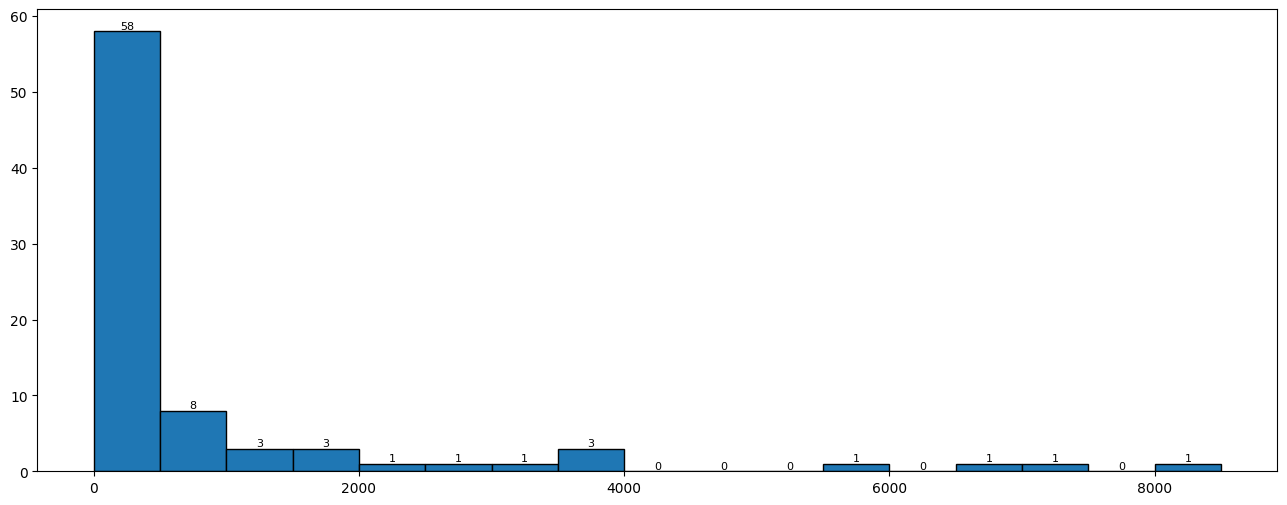

In [7]:
import matplotlib.pyplot as plt
found_ranks = [rank for rank in bge_ranks if rank != -1]
max_rank = max(found_ranks)
bin_edges = list(range(0, ((max_rank // 500) + 2) * 500, 500))
plt.figure(figsize=(16, 6))
counts, bins, patches = plt.hist(found_ranks, bins=bin_edges, edgecolor='black')
for count, bin_left, patch in zip(counts, bins, patches):
    plt.text(
        bin_left + (bins[1] - bins[0]) / 2,
        count,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=8
    )
plt.show()

In [8]:
for i, rank in enumerate(bge_ranks):
    print(f"index: {i}, lowest index of target doi (rank - 1): {rank}")

index: 0, lowest index of target doi (rank - 1): -1
index: 1, lowest index of target doi (rank - 1): 596
index: 2, lowest index of target doi (rank - 1): 7281
index: 3, lowest index of target doi (rank - 1): 1972
index: 4, lowest index of target doi (rank - 1): 0
index: 5, lowest index of target doi (rank - 1): 24
index: 6, lowest index of target doi (rank - 1): 0
index: 7, lowest index of target doi (rank - 1): 503
index: 8, lowest index of target doi (rank - 1): -1
index: 9, lowest index of target doi (rank - 1): 468
index: 10, lowest index of target doi (rank - 1): -1
index: 11, lowest index of target doi (rank - 1): -1
index: 12, lowest index of target doi (rank - 1): 5
index: 13, lowest index of target doi (rank - 1): 1
index: 14, lowest index of target doi (rank - 1): -1
index: 15, lowest index of target doi (rank - 1): 20
index: 16, lowest index of target doi (rank - 1): 1272
index: 17, lowest index of target doi (rank - 1): 164
index: 18, lowest index of target doi (rank - 1): 

## Big Misses

Having used top-k of 10,000 even then some target references weren't retrieved. We see the 3rd example had one of the worst results where its target doi first appeared at index 7281.

Let's take a look at this example:
1. Get the example
1. Look at the sentence and the target citation
1. Look at the 7281st index to see its target chunk
1. Find out if any of the other query results after that were also from the target doi
1. Look at the top-ranked results' chunks
1. Hypothesize why their vector embeddings were so much closer

In [9]:
example = examples.iloc[2]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Building on their ideas, Priest and Syntelis ( 2021 ) '
 'developed a model in which the magnetic field is written in terms of '
 'cylindrical polar coordinates , asdue to a ring of X-points near and the '
 'field of the current sheet itself.')
('Example: Building on their ideas, Priest and  developed a model in which the '
 'magnetic field is written in terms of cylindrical polar coordinates , asdue '
 'to a ring of X-points near and the field of the current sheet itself.')
Target doi: ['10.3847/1538-4357/abec4f']


This target doi *actually* refers to *The Dynamic Formation of Pseudostreamers* (Scott et al, 2021), bibcode `2021ApJ...913...64S`. 

However, "Priest and Syntelis (2021)" should have been the target document. So in this case the example was misformed because
* the citation regex did not capture "Priest" as first author, but actually "Syntelis"
* Therefore it looked for a bibcode `2021........S"
* Which it matched to the incorrect document

### Conclusion: the dataset build pipeline misidentified a target document from an inline citation, creating a malformed example

Let's try with example 18, the worst-performing one in the dataset

In [10]:
example = examples.iloc[18]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: In an influential paper, Dalal Kochanek (2002) analyzed '
 'radio data for a sample of seven quadruply-imaged sources and reported the '
 'detection of a surface mass fraction in the form of substructure between '
 '0.6% and 7%.')
('Example: In an influential paper, Dalal  analyzed radio data for a sample of '
 'seven quadruply-imaged sources and reported the detection of a surface mass '
 'fraction in the form of substructure between 0.6% and 7%.')
Target doi: ['10.1046/j.1365-8711.2002.05438.x']


Dalal Kochanek (2002) should refer to the paper *Direct Detection of Cold Dark Matter Substructure*, bibcode `2002ApJ...572...25D` and doi " 
10.1086/340303" or "10.48550/arXiv.astro-ph/0111456". We see here the target DOI has again been malformed.

### Conclusion: malformed example

In [11]:
example = examples.iloc[19]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Although this is often interpreted as “preheating”, soft '
 'X-ray images show that in many cases the precursor, though a part of the '
 'flare, does not coincide with the structure supporting the impulsive phase '
 '(Fárník and Savy 1998), hence not reflecting the plasma conditions at the '
 'site of major energy release.')
('Example: Although this is often interpreted as “preheating”, soft X-ray '
 'images show that in many cases the precursor, though a part of the flare, '
 'does not coincide with the structure supporting the impulsive phase (Fárník '
 'and , hence not reflecting the plasma conditions at the site of major energy '
 'release.')
Target doi: ['10.1023/A:1005033717284']


### Conclusion: again, malformed example due to inline citation regex failing to capture first author

In [12]:
example = examples.iloc[33]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Prior to launch, synthetic white light WISPR images, '
 'created using the sophisticated ray-tracing software (Thernisien et al. 2009 '
 '), were used to develop new techniques for analyzing observed motions of '
 'ejecta.')
('Example: Prior to launch, synthetic white light WISPR images, created using '
 'the sophisticated ray-tracing software (, were used to develop new '
 'techniques for analyzing observed motions of ejecta.')
Target doi: ['10.1007/s11207-009-9346-5']


Thernisien et al. 2009 does refer to DOI: 10.1007/s11207-009-9346-5. So in this case the example has the correct target doi.

The input sentence refers to the ray-tracing software from Thernisien et al. 2009. So hopefully the target chunk talks about this.

Inspecting the chunk retrieved:

In [13]:
example_query_results = bge_query_results[33]
query_result_idx = bge_ranks[33]
pprint(example_query_results[query_result_idx])

VectorQueryResult(chunk_id=1216498,
                  doi='10.1007/s11207-009-9346-5',
                  title='Forward Modeling of Coronal Mass Ejections Using '
                        'STEREO/SECCHI Data',
                  abstract='We describe a forward modeling method developed to '
                           'study the coronal mass ejections observed with '
                           'STEREO/SECCHI. We present a survey of 26 CMEs '
                           'modeled with this method. We selected most of the '
                           'bright events observed since November 2007 to '
                           'August 2008, after when the separation was greater '
                           'than 40° degrees, thus showing noticeable '
                           'differences between the two views. From these '
                           'stereoscopic observations and using a geometric '
                           'model of a flux rope, we are able to determine the '
             

We see this particular chunk does not seem to be particularly similar to the sentence that cites the document, rather a part of the process described which, out of context, it would be hard to recognize as related to the input sentence.

Recompiling the paper:

In [16]:
research_papers = pd.read_json("data/preprocessed/research.jsonl", lines=True)
print(f"Number of research papers: {len(research_papers)}")


Number of research papers: 52618


In [20]:
thernesien_paper = research_papers[research_papers["doi"] == "10.1007/s11207-009-9346-5"]
print(f"Papers found with target doi in reference data: {len(thernesien_paper)}")
thernesien_paper = thernesien_paper.iloc[0]
print(f"Title: {thernesien_paper['title']}")

Papers found with target doi in reference data: 1
Title: Forward Modeling of Coronal Mass Ejections Using STEREO/SECCHI Data


In [25]:
with open('thernesien_paper.txt', 'w') as f:
    f.write(thernesien_paper["title"])
    f.write("\n")
    f.write(thernesien_paper["abstract"])
    f.write("\n")
    f.write(thernesien_paper["body"])
    f.write("\n")

Let's take a look at the actual paper we have on hand

Reviewing the content of the paper, the ray-tracing software is only briefly mentioned in section 3 and 4 and not directly mentioned in the abstract:

> (3) Finally, the model can be positioned in space using spherical coordinates, as shown in Figure 1(c): φ and θ are the longitude and the latitude, respectively, and γ is the tilt angle around the axis of symmetry of the model. Here, we focus only on the geometric aspect of the modeling, leaving the photometric aspect (i.e., the electron density) to be addressed in future studies. Accordingly, we do not compare the observed total brightness images directly to the corresponding total brightness rendered model images, but rather we compare the overall observed shape to what we define to be the wireframe of the hollow croissant. The wireframe representation is simply the set of points located on the surface of the croissant, where the profile of electron density is peaked. The advantage of using a wireframe is that it allows real-time rendering, whereas it requires few seconds to few minutes for a full Thomson scattering rendering. Figure 2 shows two synthetic coronagraph images and two wireframe images of the model, viewed in the same orientation as in Figures 1(a) and (b), face-on and edge-on, respectively. The two top images are generated using a ray-tracing renderer that takes full account of the Thomson scattering equations; the two bottom images show only the projection of the wireframe on the virtual CCD. This demonstrates clearly that the wireframe representation reproduces accurately the geometry of the Thomson scattering view. 4. The Data Although this technique can be applied to images from all the instruments of the SECCHI package, we focus our study mostly on the COR2 data since its field of view (FOV) is well adapted to observe fully developed flux-rope-like CMEs. Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference).

Section 3 references the ray-tracing, section 4 references the software SolarSoft explicitly and more about their methodology with white-light images.

In [62]:
passage = "(3) Finally, the model can be positioned in space using spherical coordinates, as shown in Figure 1(c): φ and θ are the longitude and the latitude, respectively, and γ is the tilt angle around the axis of symmetry of the model. Here, we focus only on the geometric aspect of the modeling, leaving the photometric aspect (i.e., the electron density) to be addressed in future studies. Accordingly, we do not compare the observed total brightness images directly to the corresponding total brightness rendered model images, but rather we compare the overall observed shape to what we define to be the wireframe of the hollow croissant. The wireframe representation is simply the set of points located on the surface of the croissant, where the profile of electron density is peaked. The advantage of using a wireframe is that it allows real-time rendering, whereas it requires few seconds to few minutes for a full Thomson scattering rendering. Figure 2 shows two synthetic coronagraph images and two wireframe images of the model, viewed in the same orientation as in Figures 1(a) and (b), face-on and edge-on, respectively. The two top images are generated using a ray-tracing renderer that takes full account of the Thomson scattering equations; the two bottom images show only the projection of the wireframe on the virtual CCD. This demonstrates clearly that the wireframe representation reproduces accurately the geometry of the Thomson scattering view. 4. The Data Although this technique can be applied to images from all the instruments of the SECCHI package, we focus our study mostly on the COR2 data since its field of view (FOV) is well adapted to observe fully developed flux-rope-like CMEs. Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference)."
embeddings = bge_embedder([example.sent_no_cit, passage])
example_embedding = embeddings[0]
passage_embedding = embeddings[1]

# Get the cosine distance between the two embeddings using numpy
def cosine_distance(a, b):
    """
    Calculate the cosine distance between two vectors.
    :param a: The first vector.
    :param b: The second vector.
    :return: The cosine distance between the two vectors.
    """
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return 1 - np.dot(a, b)
print("Cosine distance:", cosine_distance(example_embedding, passage_embedding))

Cosine distance: 0.21922433


In [63]:
section_3 = "(3) Finally, the model can be positioned in space using spherical coordinates, as shown in Figure 1(c): φ and θ are the longitude and the latitude, respectively, and γ is the tilt angle around the axis of symmetry of the model. Here, we focus only on the geometric aspect of the modeling, leaving the photometric aspect (i.e., the electron density) to be addressed in future studies. Accordingly, we do not compare the observed total brightness images directly to the corresponding total brightness rendered model images, but rather we compare the overall observed shape to what we define to be the wireframe of the hollow croissant. The wireframe representation is simply the set of points located on the surface of the croissant, where the profile of electron density is peaked. The advantage of using a wireframe is that it allows real-time rendering, whereas it requires few seconds to few minutes for a full Thomson scattering rendering. Figure 2 shows two synthetic coronagraph images and two wireframe images of the model, viewed in the same orientation as in Figures 1(a) and (b), face-on and edge-on, respectively. The two top images are generated using a ray-tracing renderer that takes full account of the Thomson scattering equations; the two bottom images show only the projection of the wireframe on the virtual CCD. This demonstrates clearly that the wireframe representation reproduces accurately the geometry of the Thomson scattering view."
section_4 = "4. The Data Although this technique can be applied to images from all the instruments of the SECCHI package, we focus our study mostly on the COR2 data since its field of view (FOV) is well adapted to observe fully developed flux-rope-like CMEs. Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference)."
section_3_embedding = bge_embedder([section_3])[0]
section_4_embedding = bge_embedder([section_4])[0]
print("Cosine distance between section 3 and input", cosine_distance(section_3_embedding, example_embedding))
print("Cosine distance between section 4 and input", cosine_distance(section_4_embedding, example_embedding))


Cosine distance between section 3 and input 0.22012842
Cosine distance between section 4 and input 0.21376169


This substring from section 4 seems particularly relevant:

> Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference).

In [64]:
passage_2 = "Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference)."
embedding_2 = bge_embedder([passage_2])[0]
print("Cosine distance:", cosine_distance(passage_embedding, embedding_2))

Cosine distance: 0.037793636


This has the best cosine distance by far. Where is it in the chunks?

Compare it to the chunk the preprocessing pipeline inserted into the database:

In [31]:
chunks = db.query("SELECT chunk FROM lib WHERE doi = '10.1007/s11207-009-9346-5'")
print(f"Number of chunks found with target doi in reference data: {len(chunks)}")
chunks = [chunk[0] for chunk in chunks]

Number of chunks found with target doi in reference data: 41


In [60]:
for i, chunk in enumerate(chunks):
    if "ray-tracing renderer" in chunk:
        pprint(f"Found chunk {i}: {chunk}")
    if "The images are prepared using the standard SolarSoft" in chunk:
        pprint(f"Found chunk {i}: {chunk}")

('Found chunk 3: The two top images are generated using a ray-tracing renderer '
 'that takes full account of the Thomson scattering equations; the two bottom '
 'images show only the projection of the wireframe on the virtual CCD. This '
 'demonstrates clearly that the wireframe representation reproduces accurately '
 'the geometry of the Thomson scattering view. 4. The Data Although this '
 'technique can be applied to images from all the instruments of the SECCHI '
 'package, we focus our study mostly on the COR2 data since its field of view '
 '(FOV) is well adapted to observe fully developed flux-rope-like CMEs. '
 'Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 '
 'Comparison between white-light and wireframe rendering. On top are the '
 'simulated white-light images using Thomson scattering of the GCS model as '
 'seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe '
 'views. fully developed in the COR1 FOV, while its overall structu

Both those key phrases appear in chunk 3, which is part of section 3 and all of section 4

What would the cosine distance be to this chunk? To all chunks?

In [40]:
chunk_3_embedding = bge_embedder([chunks[3]])[0]
print(cosine_distance(chunk_3_embedding, example_embedding))

0.20967066


In [46]:
cosine_distances = []

for i, chunk in enumerate(chunks):
    embedding = bge_embedder([chunk])[0]
    cosine_distance_value = cosine_distance(embedding, example_embedding)
    cosine_distances.append(cosine_distance_value)

min_distance = min(cosine_distances)
print(f"Shortest distance of all chunks from this paper: {min_distance}")
best_idx = cosine_distances.index(min_distance)
print(f"At index: {best_idx}")
pprint(f"Chunk: {chunks[best_idx]}")

Shortest distance of all chunks from this paper: 0.20767277479171753
At index: 40
('Chunk: Astrophys. J. 628, 1061 – 1069. doi:10.1086/430846. Frazin, R.A., '
 'Kamalabadi, F.: 2005b, Rotational tomography for 3D reconstruction of the '
 'white-light and EUV corona in the post-SOHO era. Solar Phys. 228, 219 – 237. '
 'doi:10.1007/s11207-005-2764-0. Frazin, R.A., Butala, M.D., Kemball, A., '
 'Kamalabadi, F.: 2005, Time-dependent reconstruction of nonstationary objects '
 'with tomographic or interferometric measurements. Astrophys. J. 635, L197 – '
 'L200. doi:10.1086/499431. Howard, R.A., Sheeley, N.R. Jr., Michels, D.J., '
 'Koomen, M.J.: 1985, Coronal mass ejections – 1979 – 1981. J. Geophys. Res. '
 '90, 8173 – 8191. Howard, R.A., Moses, J.D., Vourlidas, A., Newmark, J.S., '
 'Socker, D.G., Plunkett, S.P., Korendyke, C.M., Cook, J.W., Hurley, A., '
 'Davila, J.M., Thompson, W.T., St Cyr, O.C., Mentzell, E., Mehalick, K., '
 'Lemen, 130 A. Thernisien et al. J.R., Wuelser, J.P., Dunc

So the chunk containing the substring with really good Strangely, an excerpt from the paper's end matter is the closest chunk by cosine distance. Were there in fact any other chunks from this paper included?

In [48]:
example_query_results = bge_query_results[33]
results_from_target_doi = [result for result in example_query_results if result.doi == "10.1007/s11207-009-9346-5"]
print(f"Number of results from target doi: {len(results_from_target_doi)}")

# No other references found except this one chunk

Number of results from target doi: 1


#### Observations so far:

1. What appears to be the most relevant passage does not clearly indicate the contribution (ray-tracing software) described by the inline citation
1. The human-preferred chunk in the database was not retrieved in the top 10000 results with 40 probes.
1. It's possible the other parts of the input sentence, referring to WISPR images and ejecta motions, may have overridden the ray-tracing citation when embedding

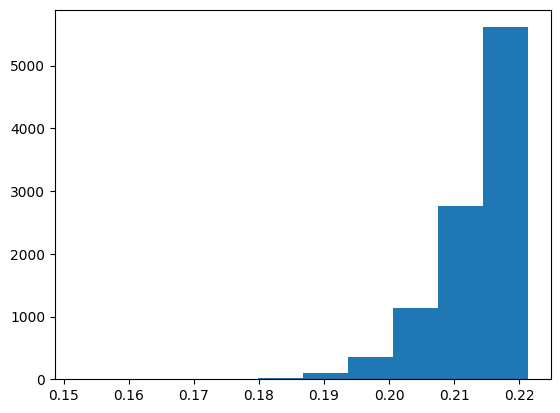

In [52]:
plt.hist([result.distance for result in example_query_results])
plt.show()

In [53]:
worse_retrieved = len([result for result in example_query_results if result.distance > 0.20967066])
print(f"Number of results with distance > 0.20967066: {worse_retrieved}")

Number of results with distance > 0.20967066: 7767


So if the database query had retrieved the true closest chunk, it still would have been ranked about 2232

#### Look at what records were deemed more similar

In [57]:
for i, result in enumerate(example_query_results[:3]):
    pprint(f"Rank {i} (distance {result.distance:.4f}): {result.chunk}") 

('Rank 0 (distance 0.1521): 3 This was shown experimentally by Piekutowski '
 '(1980) , and confirmed in our own experiments and recent code calculations. '
 'At least five different techniques have been used to measure the ejection '
 'velocity as a function of position, i.e. v ( x ): (1) Piekutowski et al. '
 '(1977) measured velocities for small explosion events by using a sheet of '
 'light perpendicular to the target surface to illuminate a single plane of '
 'the ejecta plume. A camera with a rotating shutter recorded the positions of '
 'ejecta particles at discrete times, from which their trajectories could be '
 'determined. (2) Cintala et al. (1999) improved on this method by using a '
 'strobed laser and a CCD camera to record the trajectories. Once the '
 'trajectories were known, ballistic equations were used to determine the '
 'launch position, speed and angle. (3) An optical technique originally '
 'developed in the fluid mechanics community for visualization of flow fi

Thoughts:
1. The top-ranked chunk discusses ejecta a lot.
1. The second top-ranked chunk is short, but mentions rays and forward modeling (which is what the software does)
1. The third result mentions color maps
1. None of these results seem to discuss the input sentence topic much, and neither do they have particularly close scores

### Conclusion: this would be a difficult example no matter what, but if the chunking had been more granular we might have nailed it

In [66]:
example = examples.iloc[48]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: doi:10.1086/185542 Belsole E, Worrall DM, Hardcastle MJ, '
 'Birkinshaw M, Lawrence CR (2004) XMM-Newton observations of three '
 'high-redshift radio galaxies.')
('Example: doi:10.1086/185542 Belsole E, Worrall DM, Hardcastle MJ, Birkinshaw '
 'M, Lawrence  XMM-Newton observations of three high-redshift radio galaxies.')
Target doi: ['10.1007/BF02702288']


### Conclusion: this example has very little semantic content, and appears to be from the end matter. It should not have been an example at all

In [82]:
example = examples.iloc[67]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")
print(example.pubdate)

('Original sentence: Using a theoretical HR diagram, it is possible to derive '
 'an empirical relation between A~f and the luminosity L (Lamers, 1981), and, '
 'going one step further, and A~f—M relation (since for high masses, the '
 'luminosity remains approximately constant throughout the evolution), in the '
 'form: J~f)~MI~ 2=108MoY~11 M>Mmn=20M.')
('Example: Using a theoretical HR diagram, it is possible to derive an '
 'empirical relation between A~f and the luminosity L (, and, going one step '
 'further, and A~f—M relation (since for high masses, the luminosity remains '
 'approximately constant throughout the evolution), in the form: J~f)~MI~ '
 '2=108MoY~11 M>Mmn=20M.')
Target doi: ['10.1086/158835']
1983-10-01


The target DOI is correct. This appears to be OCR errors, mistaking $\dot{M}$ for `A~f`. The original has very different notation:

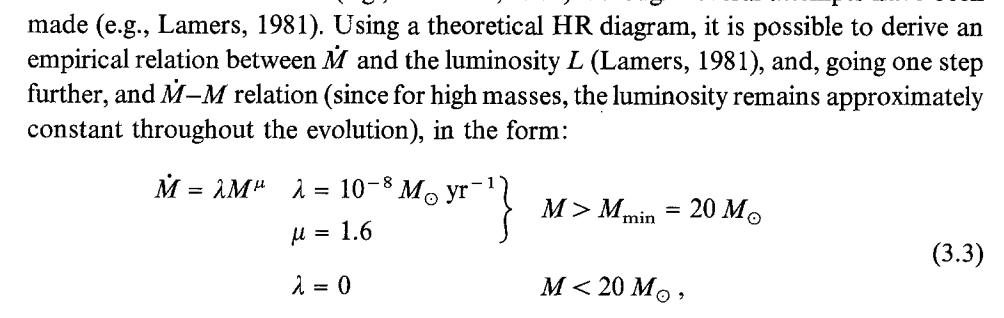

In [81]:
# display 'data/images/gamma_rays_screenshot.png' image
from IPython.display import Image, display
display(Image(filename='data/images/gamma_rays_screenshot.png'))

Let's see how vector search would have worked if we had the right input text. Note that this passage discusses:
- HR diagram which relates luminosity (magnitude) to temperature
- Further notes that luminosity is roughly constant for high masses
- Equations relating mass to luminosity

Using latex:

In [83]:
latex_input = """
Using a theoretical HR diagram, it is possible to derive an empirical relation between $\dot{M}$ and the luminosity $L$, and, going one step further, and $\dot{M} - M$ relation (since for high masses, the luminosity remains approximately constant throughout the evolution), in the form:

\[
\left.
\begin{aligned}
  \dot{M} = \lambda M^\mu \qquad &\lambda = M_\odot \text{yr}^{-1} \\
  &\mu = 1.6
\end{aligned}
\right\}
\quad M > M_\text{min} = 20 M_\odot 
\]
\[
\lambda = 0 \qquad \qquad M < 20 M_\odot
\]
"""
latex_embedding = bge_embedder([latex_input])[0]
latex_query_results = db.query_vector_column(
    query_vector=latex_embedding,
    table_name="lib",
    target_column='bge_norm',
    pubdate=example.pubdate,
    top_k=10_000,
    probes=40,
    explain=False,
)

In [85]:
target_rank = get_index_of_target(latex_query_results, example.citation_dois[0])
print(f"Rank of target doi in latex query results: {target_rank}")
best_target_chunk = latex_query_results[target_rank]
pprint(f"Best target chunk: {best_target_chunk.chunk}")

Rank of target doi in latex query results: 2630
('Best target chunk: We adopted the temperature and radius for the individual '
 'stars from Remie and Lamers, if available, or from Underhill et al For these '
 'stars the bolometric magnitude was calculated from the temperature and the '
 'radius. Pottasch, Wessehus, and van Duinen (1979) determined empirical '
 'effective temperatures of nine O-stars from the ANS UV fluxes in combination '
 'with the Lyman continuum fluxes derived from the excitation of the diffuse '
 'nebulae surrounding the stars. We adopted their effective temperature for '
 'the star 9 Sgr. For the stars for which no integrated-flux temperature was '
 'measured, we adopted a temperature scale based on the empirical '
 'temperatures. In Table 1 we list all stars from types 03 to B 1.5 for which '
 'integrated-flux temperatures are available, from either Underhill et al, '
 'Remie and Lamers, or Pottasch, Wessehus, and van Duinen. These temperatures '
 'are about 10%

This improved the rank a little bit, from 3615 to 2630. But what did it consider even closer?


In [89]:
for i, result in enumerate(latex_query_results[:3]):
    pprint(f"Rank {i} (doi {result.doi}) (distance {result.distance:.4f}): {result.chunk}")
    print()

('Rank 0 (doi 10.1086/154245) (distance 0.0599): Due We have fitted equation '
 '(1) to many of the observed luminosity functions, quoted earlier in this '
 'section, to determine A, B, and a for them, and hence to obtain the '
 'predicted M(i) = f(Nc) relation. Figure 4 shows a fit to the data given by '
 'Abell (1969), normalized such that A, B, and a give M(l) = —23.2 at log Nc = '
 '2.15 as required by the present data (Figs. 2 and 3). It is easily shown '
 'that this normalization requires A = — 20.067, B = —10.202, and a = 0.384 '
 'which, with equation (1), produces the curve drawn in Figure 4. The '
 'predicted M(l) = /(AQ relation for this model is marked as the “Abell '
 'luminosity function” in Figure 5. It is evident that the predicted '
 'dependence of M(l) on richness is much steeper than the observations (open '
 'circles, with error bars from Table 2). Clearly, the luminosity function at '
 'the bright end must be steepened.')

('Rank 1 (doi 10.1086/146489) (distance 0.

We see that vector similarity has preferred passages that discuss relations between M and L, which the passage discusses. However the citation in the passage only relates to the "empirical relation between $\dot{M}$ and $L$". The passage's vector embedding might be unduly affected by the equations.

Let's try just embedding up to the citation:

In [95]:
short_input = "Using a theoretical HR diagram, it is possible to derive an empirical relation between $\dot{M}$ and the luminosity $L$"
short_embedding = bge_embedder([short_input])[0]
short_query_results = db.query_vector_column(
    query_vector=short_embedding,
    table_name="lib",
    target_column='bge_norm',
    pubdate=example.pubdate,
    top_k=10_000,
    probes=50,
    explain=False,
)
target_rank = get_index_of_target(short_query_results, example.citation_dois[0])
print(f"Rank of target doi in short query results: {target_rank}")
best_target_chunk = short_query_results[target_rank]

Rank of target doi in short query results: 2901


**NOTE** at 40 probes no target chunks even appeared in the top results; upping the probes to 50 got the best target chunk at rank 2901, not much better than when we started.

Let's see what would happen if we increased the probes on the latex input:

In [96]:
for i, result in enumerate(short_query_results[:3]):
    pprint(f"Rank {i} (doi {result.doi}) (distance {result.distance:.4f}): {result.chunk}")
    print()

('Rank 0 (doi 10.1086/154245) (distance 0.0837): Due We have fitted equation '
 '(1) to many of the observed luminosity functions, quoted earlier in this '
 'section, to determine A, B, and a for them, and hence to obtain the '
 'predicted M(i) = f(Nc) relation. Figure 4 shows a fit to the data given by '
 'Abell (1969), normalized such that A, B, and a give M(l) = —23.2 at log Nc = '
 '2.15 as required by the present data (Figs. 2 and 3). It is easily shown '
 'that this normalization requires A = — 20.067, B = —10.202, and a = 0.384 '
 'which, with equation (1), produces the curve drawn in Figure 4. The '
 'predicted M(l) = /(AQ relation for this model is marked as the “Abell '
 'luminosity function” in Figure 5. It is evident that the predicted '
 'dependence of M(l) on richness is much steeper than the observations (open '
 'circles, with error bars from Table 2). Clearly, the luminosity function at '
 'the bright end must be steepened.')

('Rank 1 (doi 10.1086/157227) (distance 0.

In [104]:
latex_query_results = db.query_vector_column(
    query_vector=latex_embedding,
    table_name="lib",
    target_column="bge_norm",
    pubdate=example.pubdate,
    top_k=10_000,
    probes=50,
    explain=False,
)
target_rank = get_index_of_target(latex_query_results, example.citation_dois[0])
print(f"Rank of target doi in latex query results: {target_rank}")
best_target_chunk = latex_query_results[target_rank]

Rank of target doi in latex query results: 2308


In [107]:
target_chunks = db.query("SELECT chunk FROM lib WHERE doi = '10.1086/158835'")
print(len(target_chunks))
target_chunks = [chunk[0] for chunk in target_chunks]

50


In [108]:
target_embeddings = bge_embedder(target_chunks)
distances = [cosine_distance(target_embeddings[i], latex_embedding) for i in range(len(target_embeddings))]
print(f"Distances: {distances}")

Distances: [np.float32(0.105336905), np.float32(0.1251778), np.float32(0.12003881), np.float32(0.125184), np.float32(0.10948253), np.float32(0.12677205), np.float32(0.1067853), np.float32(0.15063918), np.float32(0.15641904), np.float32(0.16233224), np.float32(0.121174335), np.float32(0.12192857), np.float32(0.0994001), np.float32(0.106446564), np.float32(0.115964055), np.float32(0.13476789), np.float32(0.12741375), np.float32(0.10291386), np.float32(0.11088812), np.float32(0.117426455), np.float32(0.15274394), np.float32(0.10144174), np.float32(0.10433066), np.float32(0.12506843), np.float32(0.122748315), np.float32(0.10922307), np.float32(0.12239075), np.float32(0.11030978), np.float32(0.107153), np.float32(0.10072124), np.float32(0.10982418), np.float32(0.121797204), np.float32(0.1290344), np.float32(0.103826165), np.float32(0.12942815), np.float32(0.13069671), np.float32(0.14484322), np.float32(0.13099259), np.float32(0.12737602), np.float32(0.11469519), np.float32(0.106013775), np.

In [112]:
closest = min(distances)
print(f"Chunk in target doc with closest embedding distance has distance: {closest}")
closest_idx = distances.index(closest)
pprint(f"Closest chunk: {target_chunks[closest_idx]}")

Chunk in target doc with closest embedding distance has distance: 0.0994001030921936
('Closest chunk: This results in a homogeneous set of mass loss rates for 53 '
 'stars of types 03 to B9 and luminosity classes from V to Ia+, including Of '
 'stars. The multiple linear regression method will be used to find the '
 'dependence of the mass flux on the stellar surface parameters geff and ■^eff '
 '> and the dependence of the mass loss rates on the stellar luminosity, '
 'radius and mass. The resulting relations will be compared with the '
 'previously derived dependence of on L or on L, R, M, and the difference '
 'between our results and those of others will be explained. The relations '
 'will be compared with the predictions for the radiation driven wind model '
 'and for the fluctuation theory. The consequences for the stellar evolution '
 'will be mentioned briefly. II. THE STELLAR PARAMETERS a) The Effective '
 'Temperatures The effective temperatures and angular diameters of 160 

This seems to be a pretty accurate passage, discussing how it used regression to relate mass flux to stellar luminosity. It has a distance of about 0.1, which is still not particularly good compared to the latex query results:

In [113]:
print(f"Rank of distance 0.0994: {sum([1 for result in latex_query_results if result.distance < 0.0994])}")

Rank of distance 0.0994: 1515


In [115]:
tiny_input = "it is possible to derive an empirical relation between $\dot{M}$ and the luminosity $L$"
tiny_embedding = bge_embedder([tiny_input])[0]
tiny_query_results = db.query_vector_column(
    query_vector=tiny_embedding,
    table_name="lib",
    target_column='bge_norm',
    pubdate=example.pubdate,
    top_k=10_000,
    probes=80,
    explain=False,
)
target_rank = get_index_of_target(tiny_query_results, example.citation_dois[0])
print(f"Rank of target doi in tiny query results: {target_rank}")

Rank of target doi in tiny query results: 4238


### Conclusions: 
- This might not be the right citation for this passage
- The passage author only intended to cite Lamers 1981 for the relation between $\dot{M}$ and $L$, and the HR diagram mention and further equations are throwing off embeddings
- The OCR errors aren't helping matters

In [116]:
example = examples.iloc[70]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")
print(example.pubdate)

('Original sentence: In order to produce a catastrophe-like behavior, '
 'Zwingmann (1987) applied a method similar to the generating function method '
 'to the analyses.')
('Example: In order to produce a catastrophe-like behavior,  applied a method '
 'similar to the generating function method to the analyses.')
Target doi: ['10.1007/BF00148523']
2003-04-01


This is the correct doi.

In [117]:
zwingmann_results = bge_query_results[70]
zwingmann_top_target_result = zwingmann_results[2704]
pprint(f"Zwingmann chunk: {zwingmann_top_target_result.chunk}")
print(zwingmann_top_target_result.doi)

('Zwingmann chunk: F(~)d3r = ~J[~*.v~i - ~ x B1) x B + (V x B) x B1)+ + p1~* '
 'v~] d3r. (B6) bW is now rewritten to give the form of (2.8). By introducing '
 'Euler potentials, B1 becomes B1 =Vx(~x(VcxxVfl)) = - Vc~ x V(~ Vfl) + Vf3 x '
 'V(~ Vc~) =7~xV~f3+V&xxVf3, (B7) by using the definitions (2.6) and (2.7) for '
 '&~ and sf3. The pressure and density perturbations then give with (1.5) '
 'pi~+~J3+p1~j-yPV/.~, (B8) ~ (B9) The terms of(2.8) can be expressed by using '
 '(B7)-(B9), and by some partial integrations 328 WOLFGANG ZWINGMANN in the '
 'following way: J ~ + J [vi)iv.~ + ~ - ~ - I ~ &~I~ + 2 Re(~,cx ~fl*) + I '
 '~I3I~l d3r (B 10) J L3LX2 3/32 j - J ~*.((~ x B1) x B)d3r= Jda.(Bi x (~* x '
 'B))+ J 1B112d3r, (Bil) - J ~ * ((V x B) x B1) d3r = J [~v x B) (~* V ~fl - '
 '~fl~V ~) - - p~ (~ (~ * V&z) + (~ * V5fl))] d3r, (B 12) J P~~V~d3r= ~ (B13) '
 'These terms are combined to give ~w=-~--- ~ 2/2~ J L - (~~P ~2 + 2 -~-~- '
 "Re(&x*~f3) + I ~flI~'~l d3r + ~p2 j] + ~ J ~ - p((~

This is also an OCR failure on math

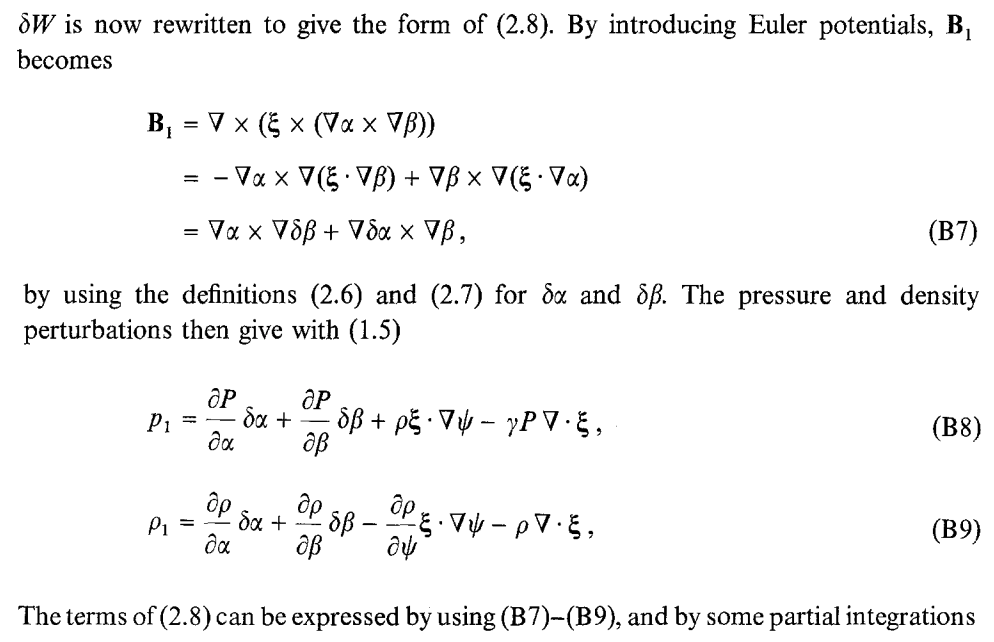

In [118]:
display(Image(filename="data/images/zwingmann.png"))

### Conclusion: the passage is mostly math notation, incorrectly scanned by OCR. 

In [119]:
example = examples.iloc[79]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")
print(example.pubdate)

('Original sentence: Initial Discoveries of Strong Lensing Systems The first '
 'strong lens, the double quasar 0957+561A, B, was discovered in 1979 by Walsh '
 'et al. ( 1979 ).')
('Example: Initial Discoveries of Strong Lensing Systems The first strong '
 'lens, the double quasar 0957+561A, B, was discovered in 1979 by .')
Target doi: ['10.1038/279381a0']
2024-12-01


This is the correct doi for the inline citation. It got the target doc at rank 2098. The passage refers to:
- The double quasar 0957+561A, B
- This is a strong lens
- Walsh et al first discovered it

In [120]:
results = bge_query_results[79]
walsh_result = results[2098]
pprint(walsh_result.chunk)

('The mean position of the two objects is 17 arcs from the radio position, so '
 'the identification is necessarily tentative. Table 1 Positions and '
 'magnitudes of 0957 + 561 A, B Object RA Dec (1950.0) MR MB0957 + 561 A 0957 '
 '+ 561B 095757.3 095757.4 +560822.9 +560816.9 17.0 17.0 16.7 17.0 '
 'Observations The two objects 0957 + 561 A, B were observed on 29 March 1979 '
 'at the 2.1 m telescope of the Kitt Peak National Observatory (KPNO) using '
 'the intensified image dissector scanner (IIDS). Sky subtraction was used '
 'with circular apertures separated by 99.4 arc s. Some observational '
 'parameters are given in Table 2. The spectral range was divided into 1,024 '
 'data bins, each bin 3.5 wide, and the spectral resolution was 16 A. After '
 '20-min integration on each object it was clear that both were QSOs with '
 'almost identical spectra and redshifts of -1.40 on the basis of strong '
 'emission lines identified as CIV ? 1549 and C ill] ? 1909. Further '
 'observations

The chunk directly refers to the twin quasar and observing it, but not as much to the lensing effect in this particular chunk.

What was considered more semantically relevant?

In [121]:
for i, result in enumerate(results[:3]):
    pprint(f"Rank {i} (doi {result.doi}) (distance {result.distance:.4f}): {result.chunk}")
    print()

('Rank 0 (doi 10.1088/1361-6633/ab4fc5) (distance 0.0599): Strong lensing was '
 'discovered for the first time in 1979 by Walsh et al [ 5 ]. The background '
 'source is a quasar, which is a very bright active galactic nucleus powered '
 'by a supermassive black hole at the center of a galaxy. Quasars are bright '
 'enough to be detected even at cosmological distances, and their compact '
 'sizes suggest that their multiple images are well separated, which make them '
 'as an ideal source for strong lensing. In the first example, the quasar '
 'Q0957+561 at redshift z = 1.4 is split into two images separated by due to '
 'the gravitational lensing effect of a foreground group of galaxies. The '
 'lensing interpretation was confirmed by the identical spectra of the two '
 'quasar images. Strong lensing of background galaxies has also been '
 'discovered. Since galaxies are much larger in size than quasars, lensed '
 'galaxies often form giant arcs, which are highly elongated galaxy ima

All these chunks directly refer to Walsh 1979, likely contributing strong similarity (distance ~ 0.06). Notably, Walsh 1979 has a title that might be highly relevant to this passage query.

Let's see what happens when we also embed the title and abstract

In [123]:
pprint(walsh_result.title)
pprint(walsh_result.abstract)

'0957+561 A, B: twin quasistellar objects or gravitational lens?'
('Within the field of the source 0957 + 561 is a close pair of blue stellar '
 'objects of magnitude 17 with a separation of 5.7 arc sec at redshift 1.405. '
 'The two sources show great similarity in their spectral characteristics. A '
 'conventional interpretation could regard as coincidence the similarity of '
 'emission spectra, or assume that the initial conditions, age and environment '
 'of the two quasars are practically identical. A less conventional view would '
 'find the quasars to be two images of the same object produced by a '
 'gravitational lens.')


In [128]:
title_chunk = f"Title: {walsh_result.title}\n\nBody: {walsh_result.chunk}"
abstract_chunk = f"Abstract: {walsh_result.abstract}\n\nBody: {walsh_result.chunk}"
chunk_title = f"Body: {walsh_result.chunk}\n\nTitle: {walsh_result.title}"
chunk_abstract = f"Body: {walsh_result.chunk}\n\nAbstract: {walsh_result.abstract}"
title_and_abstract = f"Title: {walsh_result.title}\n\nAbstract: {walsh_result.abstract}\n\nBody: {walsh_result.chunk}"

In [130]:
pprint(title_chunk)

('Title: 0957+561 A, B: twin quasistellar objects or gravitational lens?\n'
 '\n'
 'Body: The mean position of the two objects is 17 arcs from the radio '
 'position, so the identification is necessarily tentative. Table 1 Positions '
 'and magnitudes of 0957 + 561 A, B Object RA Dec (1950.0) MR MB0957 + 561 A '
 '0957 + 561B 095757.3 095757.4 +560822.9 +560816.9 17.0 17.0 16.7 17.0 '
 'Observations The two objects 0957 + 561 A, B were observed on 29 March 1979 '
 'at the 2.1 m telescope of the Kitt Peak National Observatory (KPNO) using '
 'the intensified image dissector scanner (IIDS). Sky subtraction was used '
 'with circular apertures separated by 99.4 arc s. Some observational '
 'parameters are given in Table 2. The spectral range was divided into 1,024 '
 'data bins, each bin 3.5 wide, and the spectral resolution was 16 A. After '
 '20-min integration on each object it was clear that both were QSOs with '
 'almost identical spectra and redshifts of -1.40 on the basis of strong

In [125]:
query_vector = bge_embedder([example.sent_no_cit])[0]

In [129]:
print(cosine_distance(query_vector, bge_embedder([title_chunk])[0]))
print(cosine_distance(query_vector, bge_embedder([abstract_chunk])[0]))
print(cosine_distance(query_vector, bge_embedder([chunk_title])[0]))
print(cosine_distance(query_vector, bge_embedder([chunk_abstract])[0]))
print(cosine_distance(query_vector, bge_embedder([title_and_abstract])[0]))

0.11602515
0.12238878
0.119539976
0.12340659
0.1124441


None of these enrichments particularly do anything to get the embedding closer to the query. What about the title and abstract by themselves?

In [131]:
title_only = bge_embedder([walsh_result.title])[0]
abstract_only = bge_embedder([walsh_result.abstract])[0]
print(cosine_distance(query_vector, title_only))
print(cosine_distance(query_vector, abstract_only))

0.13204706
0.11647391


Or any of the chunks from Walsh 1979?

In [132]:
walsh_chunks = [chunk[0] for chunk in db.query("SELECT chunk FROM lib WHERE doi = '10.1038/279381a0'")]
print(len(walsh_chunks))

14


In [133]:
walsh_embeddings = bge_embedder(walsh_chunks)
walsh_distances = [cosine_distance(walsh_embeddings[i], query_vector) for i in range(len(walsh_embeddings))]
print(f"Distances: {walsh_distances}")
closest = min(walsh_distances)
print(f"Chunk in target doc with closest embedding distance has distance: {closest}")
closest_idx = walsh_distances.index(closest)
pprint(f"Closest chunk: {walsh_chunks[closest_idx]}")

Distances: [np.float32(0.14022768), np.float32(0.12455821), np.float32(0.14882791), np.float32(0.1489079), np.float32(0.14485228), np.float32(0.15837085), np.float32(0.12893093), np.float32(0.13342458), np.float32(0.12892556), np.float32(0.15016615), np.float32(0.14718091), np.float32(0.13947636), np.float32(0.12611187), np.float32(0.14071149)]
Chunk in target doc with closest embedding distance has distance: 0.1245582103729248
('Closest chunk: The mean position of the two objects is 17 arcs from the '
 'radio position, so the identification is necessarily tentative. Table 1 '
 'Positions and magnitudes of 0957 + 561 A, B Object RA Dec (1950.0) MR MB0957 '
 '+ 561 A 0957 + 561B 095757.3 095757.4 +560822.9 +560816.9 17.0 17.0 16.7 '
 '17.0 Observations The two objects 0957 + 561 A, B were observed on 29 March '
 '1979 at the 2.1 m telescope of the Kitt Peak National Observatory (KPNO) '
 'using the intensified image dissector scanner (IIDS). Sky subtraction was '
 'used with circular ap

Here we see that the closest chunk from the target doc has a cosine distance of 0.1246, not that close, even though the passage is laying out original observations of the double quasar in question rather than citing others' work on the matter. Could an NLI mode have performed better?

### Conclusion: the embedding model found many other articles that also cited the same source with naturally similar semantic content. Perhaps an NLI reranker would have done the job